# PM2.5 Prediction Analysis

## Introduction

Air pollution is a critical environmental issue affecting millions of people worldwide, with particularly severe impacts in rapidly developing urban areas. Beijing, one of the world's largest cities and a major economic hub, has been grappling with significant air quality challenges for years. Among the various pollutants, PM2.5 (fine particulate matter with a diameter of 2.5 micrometers or less) is of particular concern due to its severe health impacts.

### The Impact of PM2.5
PM2.5 particles are small enough to penetrate deep into the lungs and even enter the bloodstream, leading to a range of health problems including:

- Respiratory issues (asthma, bronchitis)
- Cardiovascular diseases
- Reduced lung function
- Increased risk of stroke
- Premature death in people with heart or lung disease

Beyond health impacts, high levels of PM2.5 also affect visibility, climate, and can have significant economic consequences due to increased healthcare costs and reduced productivity.

## 1. Import Libraries

In this section, we import all necessary libraries for data manipulation, visualization, machine learning, and time series analysis. These libraries include pandas, numpy, matplotlib, seaborn, scikit-learn, and others specific to time series analysis and advanced machine learning models like XGBoost.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# import decision tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import xgboost as xgb
import os

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.signal import periodogram

import joblib


## 2. Load and Preprocess Data

Our analysis uses a comprehensive dataset that combines PM2.5 measurements from the U.S. Embassy in Beijing with meteorological data from Beijing Capital International Airport. This hourly dataset provides a rich source of information for understanding the interplay between various environmental factors and PM2.5 concentrations.

### Dataset Features:

1. **Temporal Information**: Year, Month, Day, Hour
2. **Target Variable**: PM2.5 concentration
3. **Meteorological Factors**: Dew Point, Temperature, Pressure, Wind direction and speed
4. **Precipitation Indicators**: Cumulated hours of snow and rain

In this section, we:
1. Load the CSV file containing Beijing PM2.5 data.
2. Define and apply the `preprocess_data` function to clean the data, handle missing values, and create datetime features.
3. Create two dataframes: `X` for feature-based models and `X_prophet` for time series models.
4. Check for Seasonality and Stationarity

   Here, we perform checks for seasonality and stationarity in the PM2.5 time series:
   1. The `check_seasonality` function performs multiple checks: 
      - Seasonal decomposition
      - Autocorrelation
      - Periodogram
      - Statistical test for seasonality
   2. The `check_stationarity` function uses the Augmented Dickey-Fuller test to check for stationarity.
   3. We apply both functions to our PM2.5 data to understand its temporal characteristics.
   
5. Data Splitting

   In this step, we split our data:
   1. We create a test set (`X_test_final`) containing data from October 3, 2014 onwards.
   2. The remaining data is kept in `X` for our main analysis and model training.

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Shape before dropping missing values: (43824, 13)
Shape before dropping missing values: (41757, 13)
Shape after dropping missing values: (41757, 13)


,DEWP,TEMP,PRES,Iws,pm2.5
date,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,138.0


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


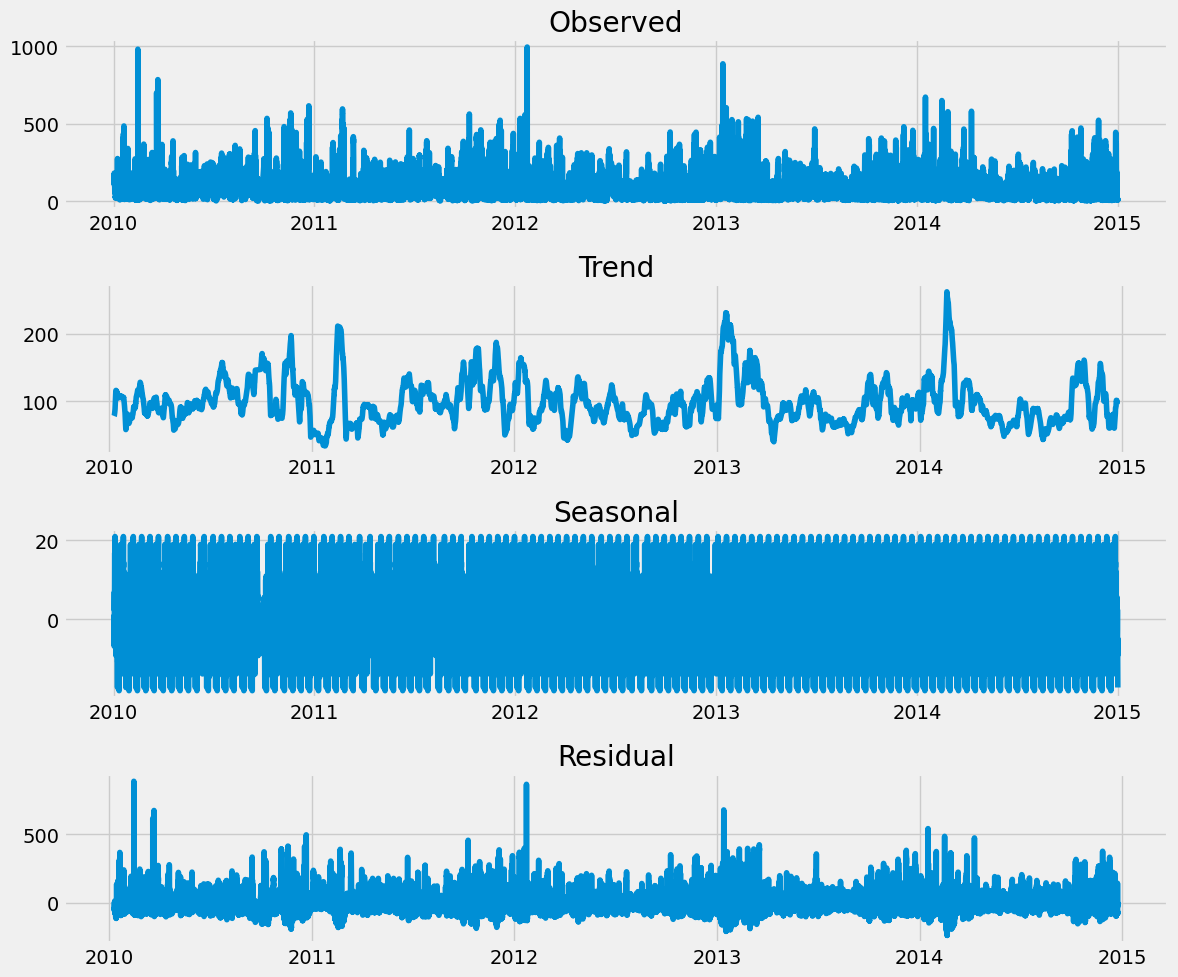

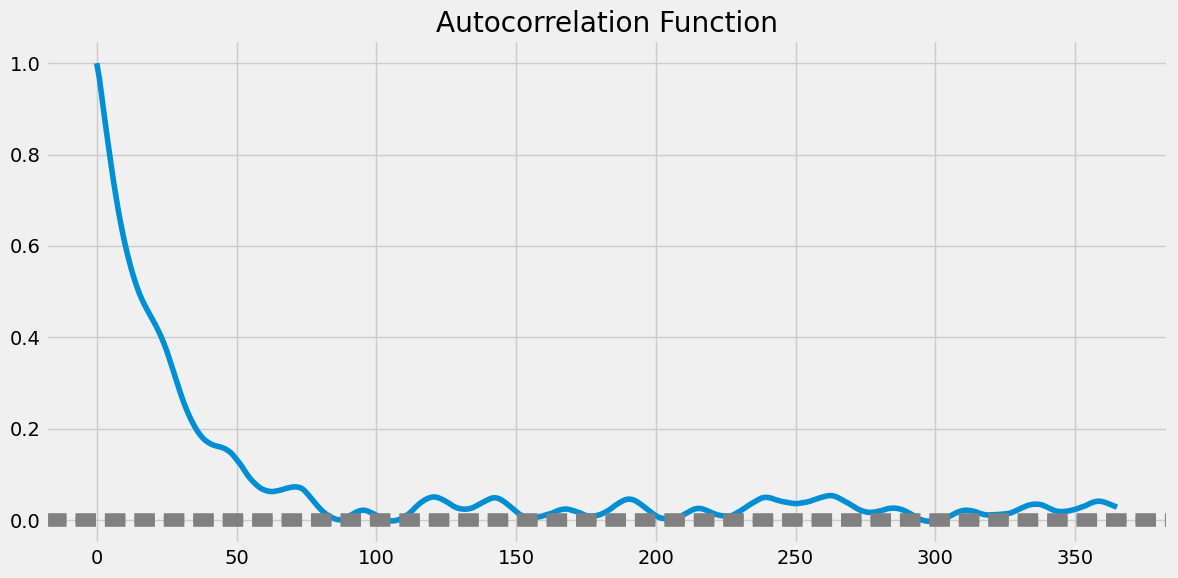

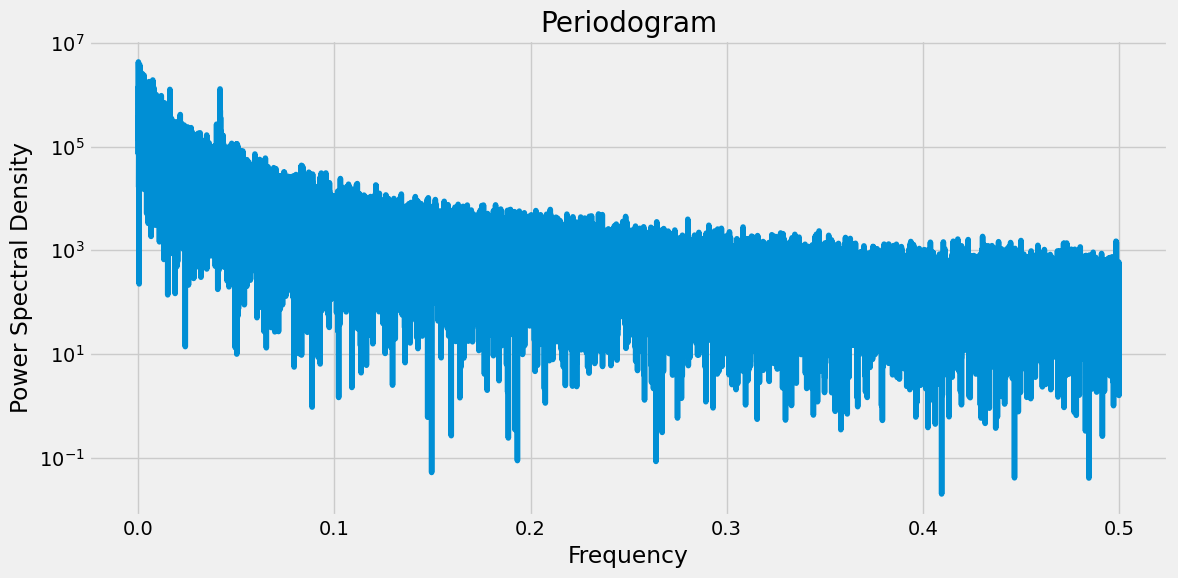

Pearson correlation for seasonality: 0.0016
p-value: 0.7463
No strong evidence of seasonality (p >= 0.05)
ADF Statistic: -20.606824646403773
p-value: 0.0
Critical Values: {'1%': -3.430506819878383, '5%': -2.8616093108616596, '10%': -2.5668068919322544}
The series is stationary
Latest datetime record: 2014-12-31 23:00:00


,DEWP,TEMP,PRES,Iws,pm2.5
date,,,,,
2014-10-06 00:00:00,5,7.0,1027.0,1.78,39.0
2014-10-06 01:00:00,6,8.0,1027.0,1.79,32.0
2014-10-06 02:00:00,6,7.0,1027.0,0.45,28.0
2014-10-06 03:00:00,5,10.0,1027.0,3.13,28.0
2014-10-06 04:00:00,5,7.0,1026.0,0.89,22.0


2014-10-02 23:00:00
Latest datetime record: 2014-10-02 23:00:00


In [18]:
df = pd.read_csv('/Users/andresjr/Documents/capgemini/Task_2_new/data/beijing_pm_25.csv')
display(df.head())


def preprocess_data(df):

    pd.options.mode.chained_assignment = None
    # Drop rows with missing target values
    print("Shape before dropping missing values:", df.shape)
    df = df.dropna(subset=['pm2.5'])

    print("Shape before dropping missing values:", df.shape)
    #drop rows with missing values
    df = df.dropna()
    print("Shape after dropping missing values:", df.shape)

        # Combine columns into a datetime object
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

    # Convert to the desired format
    df['date'] = df['datetime'].dt.strftime('%Y-%m-%d %H:00:00').astype('datetime64[ns]')

    # Drop the original columns
    df = df.drop(['year', 'month', 'day', 'hour', 'datetime'], axis=1)

    # Select features
    features = ['DEWP', 'TEMP', 'PRES', 'Iws']

    y = df['pm2.5']
    X = df[features]

    # Add the date column back to the dataframe as the first column do not use insert
    X['date'] = df['date']
    X['pm2.5'] = y
    
    X = X.set_index('date')

    #sum also missing values accross the columns
    #print(X.isnull().sum())
    
    # Set the date as the index
    X_prophet = df
    X_prophet = X_prophet.set_index('date')
    
    #drop all columns except pm2.5
    X_prophet = X_prophet.drop(columns=["No"])
    

    return X, X_prophet

def check_seasonality(y):

    """
    Perform multiple checks for seasonality in the time series.
    """
    
    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')
    
    # 1. Visual check with seasonal decomposition
    result = seasonal_decompose(y, model='additive', period=365)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(result.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(result.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(result.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(result.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()
    
    # 2. Autocorrelation check
    lag_acf = acf(y, nlags=365)
    plt.figure(figsize=(12, 6))
    plt.plot(lag_acf)
    plt.title('Autocorrelation Function')
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)), linestyle='--', color='gray')
    plt.tight_layout()
    plt.show()
    
    # 3. Periodogram
    fs = np.fft.fftfreq(len(y), d=1)
    f, Pxx_den = periodogram(y)
    plt.figure(figsize=(12, 6))
    plt.semilogy(f[1:], Pxx_den[1:])
    plt.title('Periodogram')
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.tight_layout()
    plt.show()
    
    # 4. Statistical test for seasonality
    y_diff = y.diff().dropna()
    y_diff_square = y_diff ** 2
    result = stats.pearsonr(y_diff_square[:-12], y_diff_square[12:])
    print(f"Pearson correlation for seasonality: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("The time series likely has seasonality (p < 0.05)")
    else:
        print("No strong evidence of seasonality (p >= 0.05)")

def check_stationarity(y):

    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')
    
    result = adfuller(y)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")


X, X_prophet = preprocess_data(df)
display(X.head())
display(X_prophet.head())

# Check for seasonality
check_seasonality(X['pm2.5'])
# Check for stationarity
check_stationarity(X['pm2.5'])

print("Latest datetime record:", X.index.max())

X_ = X[X.index < '2014-10-03']

X_test_final = X[X.index >= '2014-10-06']

X = X_.copy()
display(X_test_final.head())
print(X.index.max())
print("Latest datetime record:", X.index.max())

## 3. Time Series Cross-Validation

Here, we implement and example of the time series cross-validation strategy we will follow: 

1. We use `TimeSeriesSplit` from scikit-learn to create a time series cross-validation strategy.
2. The data is split into 8 folds, with each test set being 60 days (24*60*1 hours) in length.
3. We visualize each fold to understand how the data is being split over time.

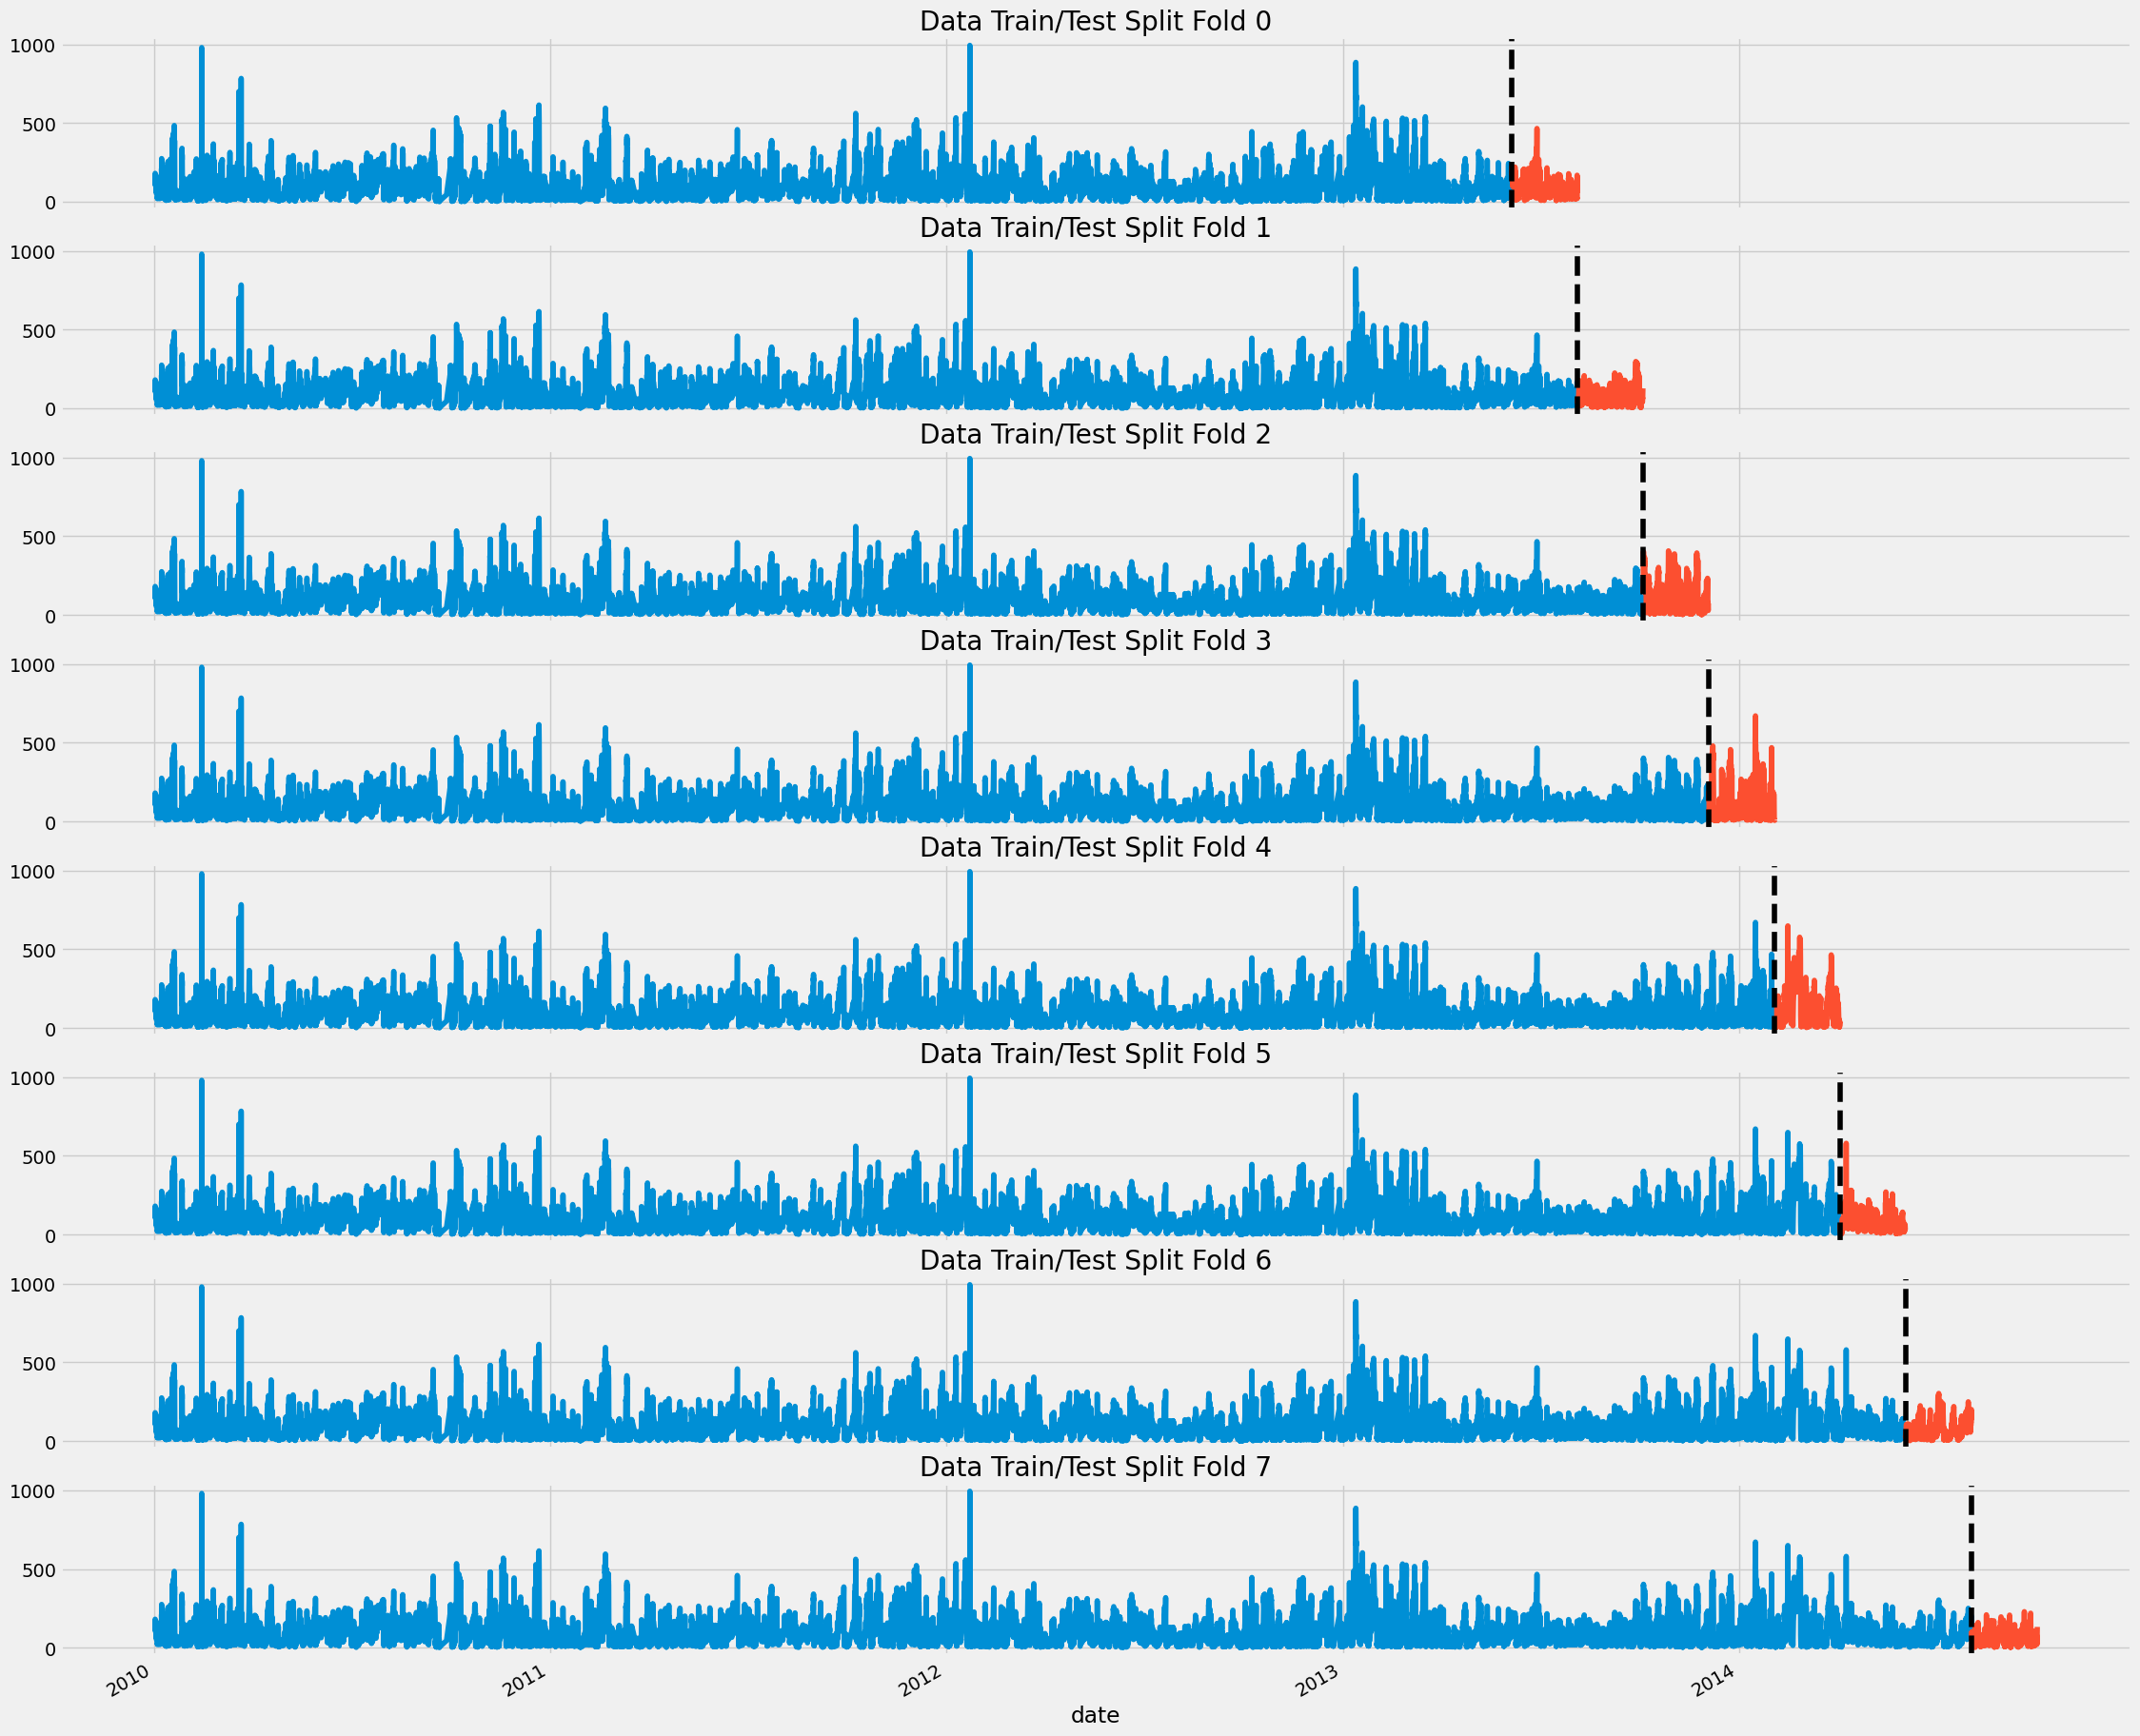

In [19]:
from sklearn.model_selection import TimeSeriesSplit

n = 8
tss = TimeSeriesSplit(n_splits=n, test_size=24*60*1, gap=0)
X = X.sort_index()

fig, axs = plt.subplots(n, 1, figsize=(25, 25), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(X):
    train = X.iloc[train_idx]
    test = X.iloc[val_idx]
    train['pm2.5'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['pm2.5'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


## 4. Feature Engineering

In this section, we perform feature engineering:
1. The `create_features` function adds time-based features like hour, day of week, month, etc.
2. The `add_lags` function creates lag features (previous year's PM2.5 values) to capture yearly patterns.

In [20]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    
    return df

def add_lags(df):
    target_map = df['pm2.5'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df


## 5. Model Training and Evaluation

Here, we define functions for model training, evaluation, and prediction:

1. `evaluate_model`: Computes various performance metrics (MSE, RMSE, MAE, R2) for a given model.
2. `train_model`: Implements the time series cross-validation strategy to train and evaluate multiple models.
3. `metrics_to_df`: Converts the performance metrics into a pandas DataFrame for easy visualization.
4. `get_predictions`: Uses a trained model to make predictions on the test set and visualize the results.

In [31]:
def train_model(X,models, tss):
    metrics = {model: {'RMSE':[],'MAE':[],'MSE':[],'R2':[]} for model in models.keys()}

    preds = {'RMSE':[],'MAE':[],'MSE':[],'R2':[]}

    model_store = {}
    for train_idx, val_idx in tss.split(X):
        train = X.iloc[train_idx]
        test = X.iloc[val_idx]

        train = create_features(train)
        test = create_features(test)
        
        for name, model in models.items():

            FEATURES = X.columns.tolist()
            
            TARGET = 'pm2.5'

            X_train = train[FEATURES]
            y_train = train[TARGET]

            X_test = test[FEATURES]
            y_test = test[TARGET]

            preds = {'RMSE':[],'MAE':[],'MSE':[],'R2':[]}

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            
            metrics_fold = evaluate_model(model,y_test,y_pred)

            for i in preds.keys():
                    metrics[name][i].append(metrics_fold[i])

            model_store[name] = model
        
    #print(metrics)
    #Take the average of the metrics for each fold
    for model_name in models.keys():
        for i in preds.keys():
            metrics[model_name][i] = np.mean(metrics[model_name][i])

    return metrics, model_store

def metrics_to_df(metrics):
        #convert the metrics to a dataframe
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.transpose()
    metrics_df = metrics_df.reset_index()
    metrics_df = metrics_df.rename(columns={'index':'model'})
    #sort the dataframe by RMSE
    metrics_df = metrics_df.sort_values(by='RMSE')
    display(metrics_df)
    return metrics_df

def get_predictions(model,model_name ,df, X_test_final):

    future_df = X_test_final
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    if model_name == 'XGBoost':
        df_and_future = add_lags(df_and_future) 
    FEATURES = set(df_and_future.columns.tolist()) - set(list(['isFuture']))

    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = model.predict(future_w_features[FEATURES])

    #compare in more detail the predictions

    print(X_test_final['pm2.5'].values)
    print(future_w_features['pred'].values)

    model_dir = os.path.join('models_results', model_name)
    os.makedirs(model_dir, exist_ok=True)


    X_test_final['pm2.5'].plot(figsize=(10, 5),
                                ms=1,
                                lw=1,
                                colormap='viridis',
                                legend=True,
                                title='Predictions for model '+str(model_name))
    future_w_features['pred'].plot(figsize=(10, 5),
                                ms=1,
                                lw=1,
                                legend=True,
                                title='Predictions for model '+str(model_name))
    
    plt.savefig(os.path.join(model_dir, 'predictions.png'))

    # Reset plot every time the function is called to avoif overlapping plots
    plt.show()
    

def evaluate_model(model,y_test,y_pred):
    metrics = {}
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse
    metrics['MAE'] = mae
    metrics['R2'] = r2
    return metrics

def create_folder_structure():
    folders = [
        #'data',
        #'data',
        #'notebooks',
        #'src',
        'models_results',
        'models_pkl'
    ]
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

## 6. Model Training and Evaluation - Basic Models

In this section, we train and evaluate multiple models:

1. We again reload and preprocess the data.
2. The data is split into training and testing sets as before.
3. We create time-based features, but this time we don't include lag features.
4. Three models are defined: 
    - Linear Regression
    - Random Forest
    - AdaBoost.
5. We use the same TimeSeriesSplit strategy as before.
6. All models are trained and evaluated using our custom functions.
7. We generate predictions for each model on the test set.
8. Finally, we save each model to a JSON file for future use.




Shape before dropping missing values: (43824, 13)
Shape before dropping missing values: (41757, 13)
Shape after dropping missing values: (41757, 13)


,model,RMSE,MAE,MSE,R2
1,RandomForest,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
0,LinearRegression,9.232880e-14,8.467498e-14,1.076264e-26,1.000000
2,AdaBoost,1.054120e+01,8.181674e+00,1.137764e+02,0.933445


/Users/andresjr/.pyenv/versions/3.7.13/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[39. 32. 28. ... 10.  8. 12.]
[10. 10. 10. ... 12. 12. 12.]


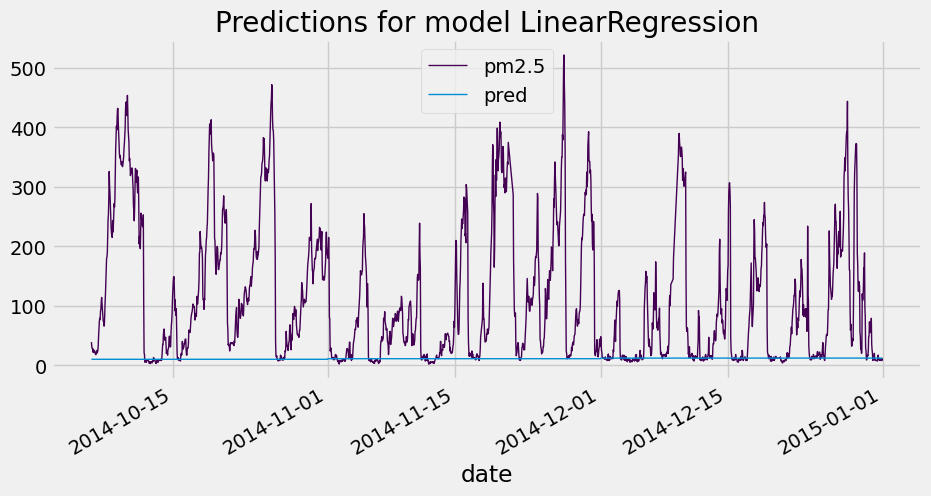

/Users/andresjr/.pyenv/versions/3.7.13/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[39. 32. 28. ... 10.  8. 12.]
[10. 10. 10. ... 12. 12. 12.]


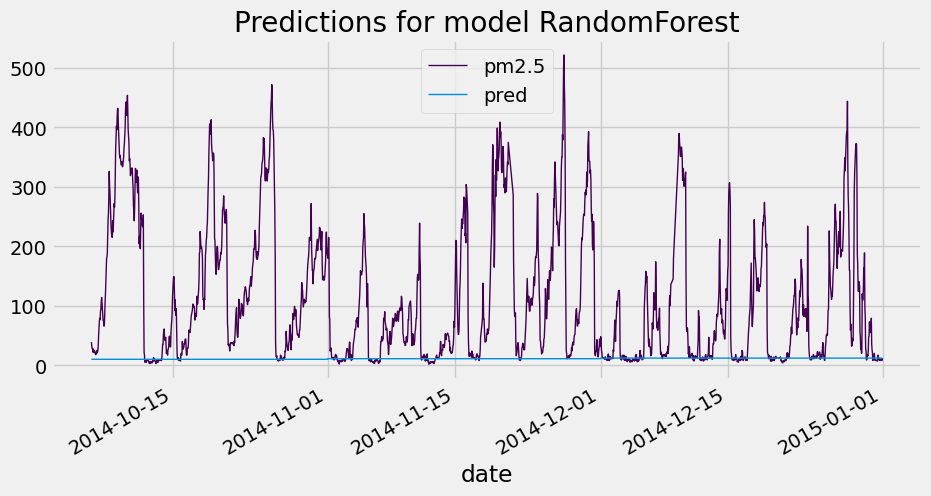

/Users/andresjr/.pyenv/versions/3.7.13/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[39. 32. 28. ... 10.  8. 12.]
[27.25904173 27.25904173 27.25904173 ... 27.25904173 27.25904173
 27.25904173]


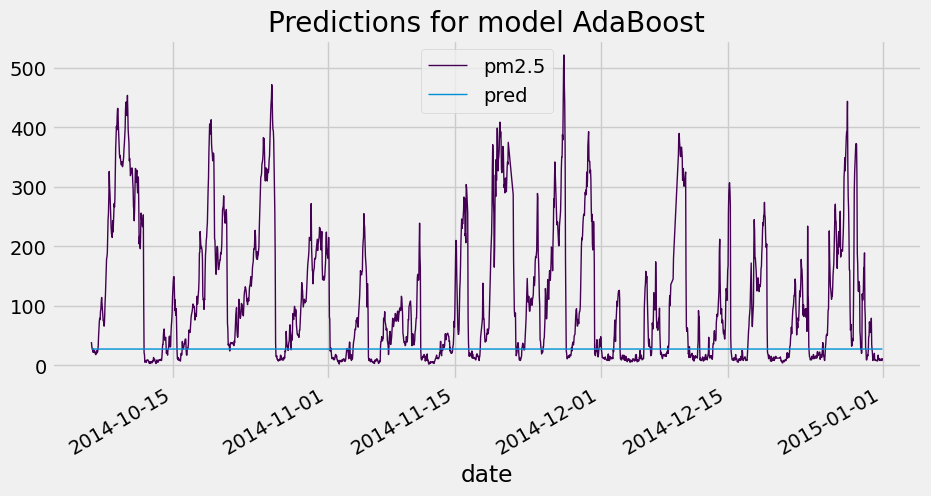

In [22]:
df = pd.read_csv('/Users/andresjr/Documents/capgemini/Task_2_new/data/beijing_pm_25.csv')
#display(df.head())

X, X_prophet = preprocess_data(df)

X_ = X[X.index < '2014-10-03']

X_test_final = X[X.index >= '2014-10-06']

X = X_.copy()

X = create_features(X)
#X = add_advanced_features(X)
#X = add_lags(X)
X.tail()

models =  {
            "LinearRegression": LinearRegression(),
            "RandomForest": RandomForestRegressor(n_estimators=100,random_state=42),
            "AdaBoost": AdaBoostRegressor(n_estimators=100,random_state=42)
        }
tss = TimeSeriesSplit(n_splits=5, test_size=12*30*1, gap=0)

metrics, model_store = train_model(X, models, tss)
metrics_df = metrics_to_df(metrics)

for model_ in model_store.keys():
    get_predictions(model_store[model_],model_,X, X_test_final)

    model_dir_pkl = os.path.join('models_pkl', model_)
    os.makedirs(model_dir_pkl, exist_ok=True)
    joblib.dump(model_store[model_], os.path.join(model_dir_pkl, 'model.pkl'))


## 7. Model Training and Evaluation - XGBoost

In this section, we train and evaluate an XGBoost model:

1. We reload and preprocess the data to ensure a fresh start.
2. The data is split into training and testing sets, with the test set containing data from September 3, 2014 onwards.
3. We create time-based features and lag features.
4. An XGBoost model is defined with specific hyperparameters.
5. We use TimeSeriesSplit with 5 folds for cross-validation.
6. The model is trained and evaluated using our custom functions.
7. We print the performance metrics and generate predictions for the test set.

Shape before dropping missing values: (43824, 13)
Shape before dropping missing values: (41757, 13)
Shape after dropping missing values: (41757, 13)


,model,MAE,MSE,R2,RMSE
0,XGBoost,0.459929,0.304798,0.999849,0.54202


     model       MAE       MSE        R2     RMSE
0  XGBoost  0.459929  0.304798  0.999849  0.54202
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
[39. 32. 28. ... 10.  8. 12.]
[7.0236197 7.9927483 7.0236197 ... 2.437045  2.437045  2.437045 ]


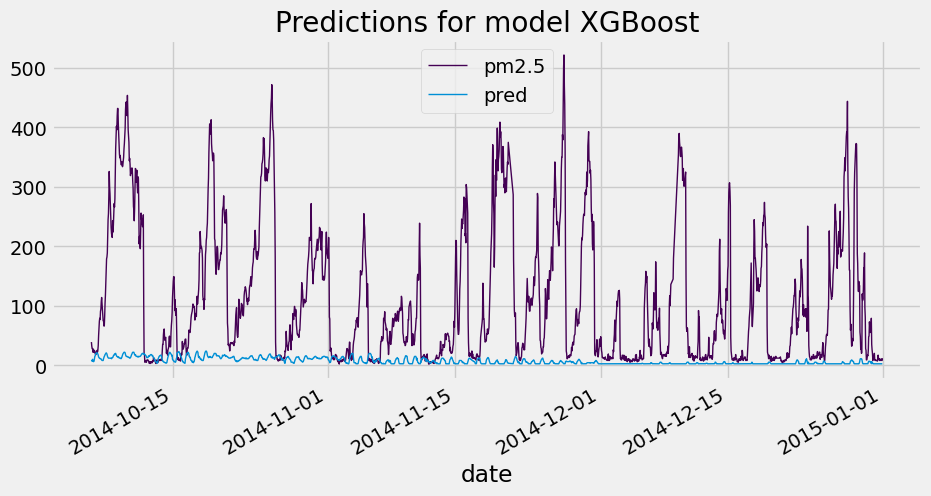

In [30]:
df = pd.read_csv('/Users/andresjr/Documents/capgemini/Task_2_new/data/beijing_pm_25.csv')
#display(df.head())

X, X_prophet = preprocess_data(df)

X_ = X[X.index < '2014-10-03']

X_test_final = X[X.index >= '2014-10-06']

X = X_.copy()

X = create_features(X)
X = add_lags(X)
X.tail()

models =  {
            'XGBoost': xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                                    n_estimators=500, 
                                    objective='reg:squarederror',
                                    max_depth=5,
                                    learning_rate=0.01),
        }

tss = TimeSeriesSplit(n_splits=5, test_size=12*30*1, gap=0)

metrics, model_store = train_model(X, models, tss)
metrics_df = metrics_to_df(metrics)
print(metrics_df)

for model_ in model_store.keys():
    print(model_store[model_])
    get_predictions(model_store[model_],model_,X, X_test_final) 
    
    model_dir_pkl = os.path.join('models_pkl', model_)
    os.makedirs(model_dir_pkl, exist_ok=True)
    joblib.dump(model_store[model_], os.path.join(model_dir_pkl, 'model.pkl'))   


## 8. Conclusion

This notebook demonstrates a comprehensive approach to analyzing and predicting PM2.5 levels in Beijing. We've covered several key aspects of time series analysis and machine learning:

1. Data preprocessing and feature engineering
2. Checking for seasonality and stationarity in the time series
3. Implementing time series cross-validation
4. Training and evaluating multiple models, including XGBoost, Linear Regression, Random Forest, and AdaBoost
5. Visualizing model performance and predictions

The results provide insights into the effectiveness of different models in predicting PM2.5 levels, which can be valuable for air quality management and public health initiatives in Beijing.


## 9. Potential Improvements

To further enhance this analysis, consider the following improvements:

1. Hyperparameter tuning: Use techniques like GridSearchCV to optimize model parameters.
2. Feature importance analysis: Identify which features contribute most to the predictions.
3. Ensemble methods: Combine predictions from multiple models to potentially improve accuracy.
4. Deep learning approaches: Experiment with LSTM or other neural network architectures for time series prediction.
5. External data integration: Incorporate additional relevant data sources, such as traffic patterns or industrial activity.
6. Longer-term forecasting: Extend the prediction horizon to provide longer-term air quality forecasts.
7. Spatial analysis: If data is available, include spatial variations in PM2.5 levels across different areas of Beijing.

These enhancements could provide even more comprehensive and accurate predictions of PM2.5 levels, further supporting air quality management efforts in Beijing.